# 라이브러리 불러오기

In [1]:
import os

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# For high resolution display
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화 함수

In [2]:
def boxplot(df, x, y, color=None, alpha=0.1, marker="<"):
    
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Dots(alpha=alpha, color=".6"), so.Jitter(), so.Dodge())
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dot(pointsize=8, marker=marker), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )


def rangeplot(df, x, y, color=None, alpha=0.1, marker="<"):

    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dot(pointsize=8, marker=marker), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

# 랜덤 시드 설정

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [4]:
data_path = "../data"
train_data = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_data = pd.read_csv(os.path.join(data_path, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
school_data = pd.read_csv(os.path.join(data_path, 'schoolinfo.csv'))
park_data = pd.read_csv(os.path.join(data_path, 'parkInfo.csv'))
subway_data = pd.read_csv(os.path.join(data_path, 'subwayInfo.csv'))
interest_data = pd.read_csv(os.path.join(data_path, 'interestRate.csv'))

In [5]:
train_data_copy = train_data.copy()

# Train EDA

- **`index`**: 인덱스 번호
- **`area_m2`**: 면적 (제곱미터)
- **`contract_year_month`**: 계약년월
- **`contract_day`**: 계약일
- **`contract_type`**: 계약 유형(0: 신규, 1:갱신, 2:모름)
- **`floor`**: 층수
- **`built_year`**: 건축 연도
- **`latitude`**: 위도
- **`longitude`**: 경도
- **`age`**: 건물의 나이 (계산된 값)
- **`deposit`**: 전세 실거래가 (타겟 변수)

In [8]:
df_eda = train_data_copy

In [9]:
print("train, test_data, sample_submission shape : ", train_data.shape, test_data.shape, sample_submission.shape)

train, test_data, sample_submission shape :  (1801228, 11) (150172, 10) (150172, 2)


In [10]:
print("train data 변수 요약 정보 확인 ")
display(train_data.describe())

train data 변수 요약 정보 확인 


,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
count,1801228.00,1801228.00,1801228.00,1801228.00,1801228.00,1801228.00,1801228.00,1801228.00,1801228.00,1801228.00,1801228.00
mean,900613.50,75.19,202133.13,15.90,1.20,10.05,2004.20,37.48,126.97,17.07,38162.23
std,519969.88,25.53,135.28,8.63,0.89,6.97,11.15,0.16,0.17,11.13,26103.77
min,0.00,10.32,201904.00,1.00,0.00,-4.00,1961.00,36.92,126.48,-3.00,300.00
25%,450306.75,59.75,202008.00,9.00,0.00,5.00,1995.00,37.38,126.84,7.00,21000.00
50%,900613.50,77.15,202111.00,16.00,2.00,9.00,2004.00,37.50,127.00,17.00,32000.00
75%,1350920.25,84.96,202212.00,23.00,2.00,14.00,2015.00,37.58,127.09,26.00,47800.00
max,1801227.00,317.36,202312.00,31.00,2.00,68.00,2024.00,38.18,127.66,62.00,1100000.00


In [11]:
print("test data 변수 요약 정보 확인 ")
test_data.describe()

test data 변수 요약 정보 확인 


,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age
count,150172.00,150172.00,150172.00,150172.00,150172.00,150172.00,150172.00,150172.00,150172.00,150172.00
mean,75085.50,74.51,202403.14,14.82,0.43,10.06,2004.91,37.47,126.97,19.09
std,43351.07,23.97,1.65,8.54,0.60,6.98,11.46,0.17,0.17,11.46
min,0.00,10.78,202401.00,1.00,0.00,-3.00,1966.00,36.96,126.48,0.00
25%,37542.75,59.76,202402.00,7.00,0.00,5.00,1995.00,37.37,126.84,8.00
50%,75085.50,75.79,202403.00,15.00,0.00,9.00,2004.00,37.50,127.00,20.00
75%,112628.25,84.96,202405.00,22.00,1.00,14.00,2016.00,37.59,127.09,29.00
max,150171.00,273.86,202406.00,31.00,2.00,60.00,2024.00,38.11,127.66,58.00


In [12]:
park_data.describe()

,latitude,longitude,area
count,17564.00,17564.00,17564.00
mean,36.54,127.47,31042.73
std,1.03,0.84,202048.66
min,31.37,125.43,0.00
25%,35.77,126.87,1501.22
50%,36.81,127.10,2240.90
75%,37.45,128.07,10263.25
max,38.49,137.20,9320660.00


## 결측값 확인

In [13]:
train_data.isna().sum()

index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
deposit                0
dtype: int64

## 중복값 확인

중복값을 어떻게 처리할 건지

- 같은 날/ 같은 건물 같은 층수가 같은 가격으로 계약 된 걸 다른 호수가 계약됐을 가능성도 있지 않나?
- 아니면 그냥 중복값은 삭제할까

In [14]:
train_data[train_data.duplicated()]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit


In [15]:
train_data[train_data.drop(columns=['index']).duplicated()]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
16,16,84.93,201907,31,2,7,2016,36.97,127.05,3,18000.00
29,29,146.40,201911,21,2,5,2016,36.97,127.05,3,37000.00
34,34,84.93,201912,14,2,14,2016,36.97,127.05,3,19000.00
42,42,84.96,202003,4,2,5,2016,36.97,127.05,4,18000.00
91,91,85.00,201911,18,2,4,2005,36.96,127.06,14,14000.00
...,...,...,...,...,...,...,...,...,...,...,...
1801153,1801153,59.94,202312,23,0,12,2011,37.53,126.65,12,30000.00
1801176,1801176,95.96,202305,29,2,5,2010,37.53,126.66,13,35000.00
1801197,1801197,101.91,202308,22,2,11,2010,37.53,126.66,13,33000.00
1801199,1801199,114.93,202308,28,1,18,2010,37.53,126.66,13,30000.00


## 이상치 확인 (boxplot으로 확인)

그래프로 봤을 때는 이상치 없어보임

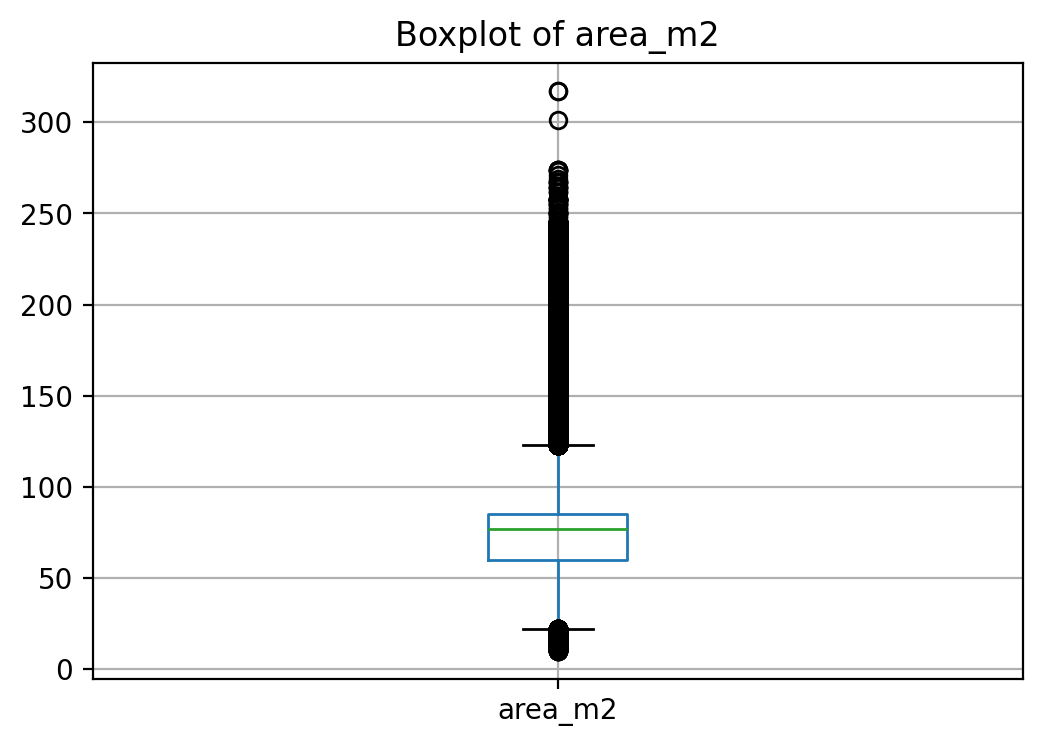

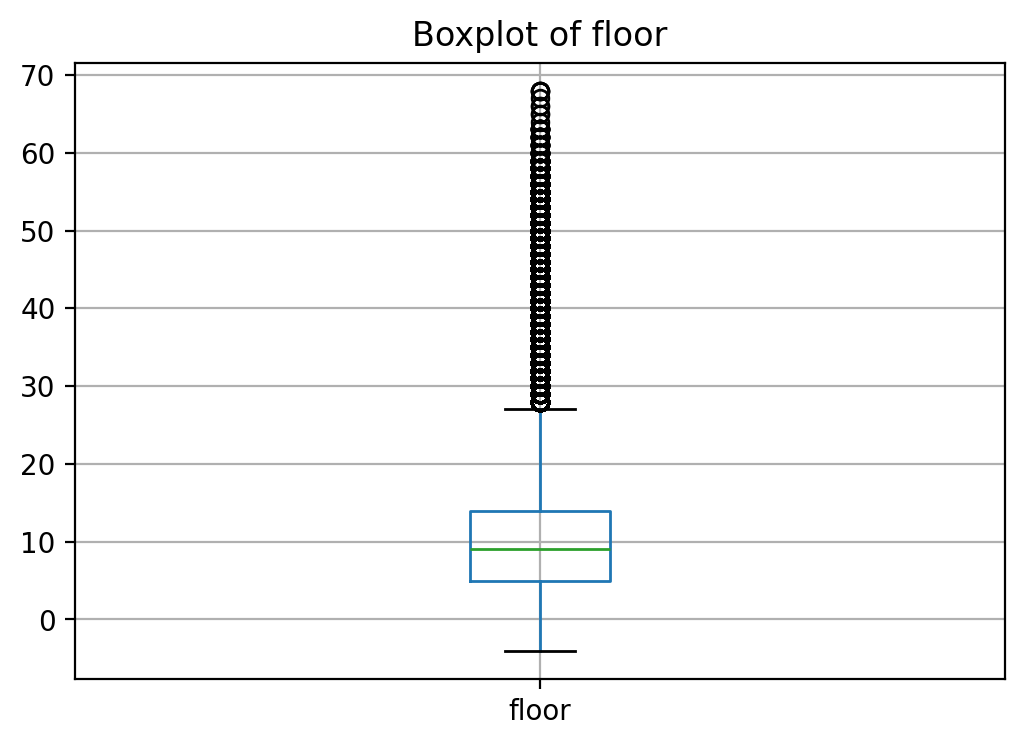

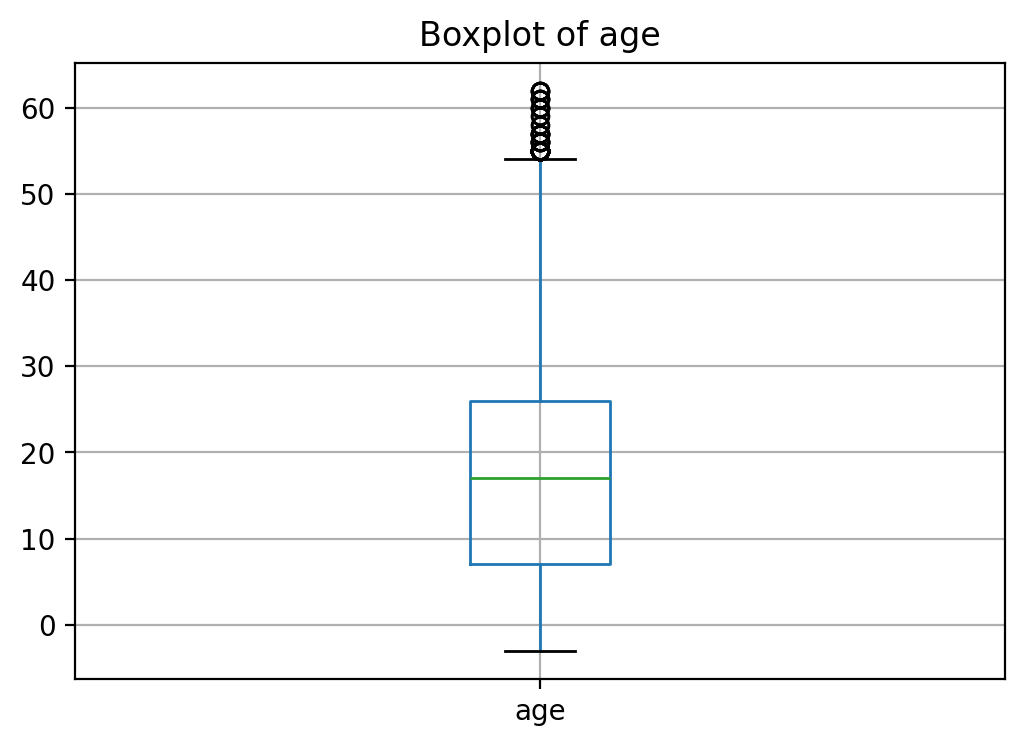

In [14]:
# 연속형 변수에 대한 boxplot 그리기
for column in ['area_m2', 'floor', 'age']:
    plt.figure(figsize=(6, 4))
    train_data[[column]].boxplot()
    plt.title(f'Boxplot of {column}')
    plt.show()


# 상관관계

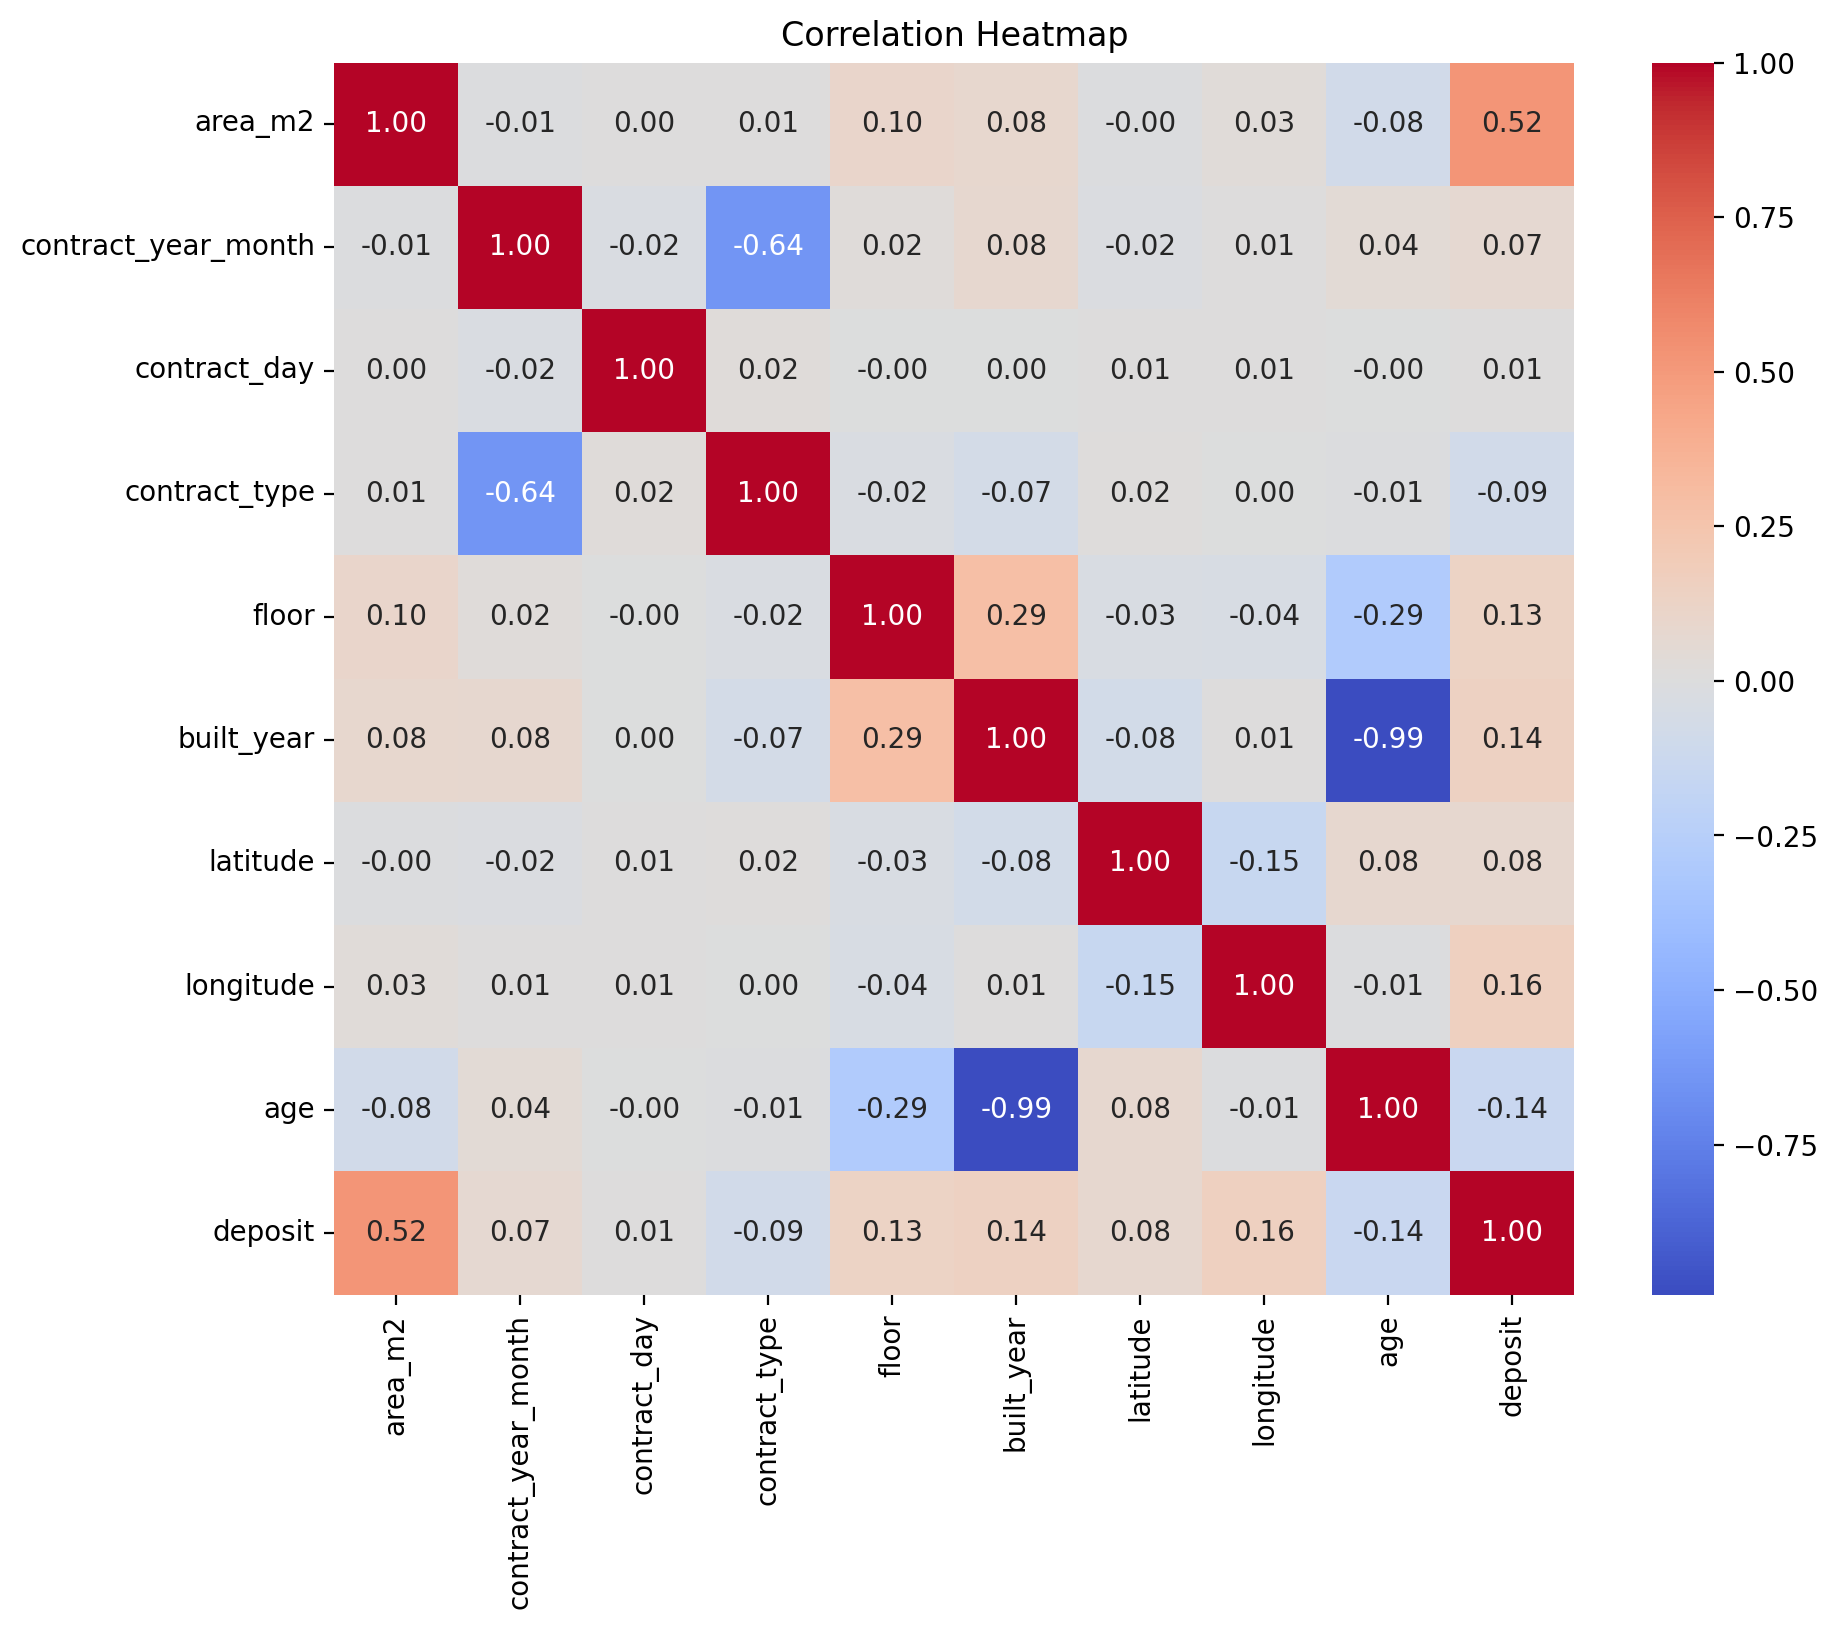

In [19]:
# 상관계수 계산
corr_matrix = df_eda[['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor',
                      'built_year', 'latitude', 'longitude', 'age', 'deposit']].corr()

# Heatmap 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()



## 분포 그래프

In [26]:
def plot_histograms(df):
    continuous_columns = df.select_dtypes(include='number').columns
    
    # Plotting histograms using Seaborn
    for column in continuous_columns:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[column], kde=False, bins=30)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()


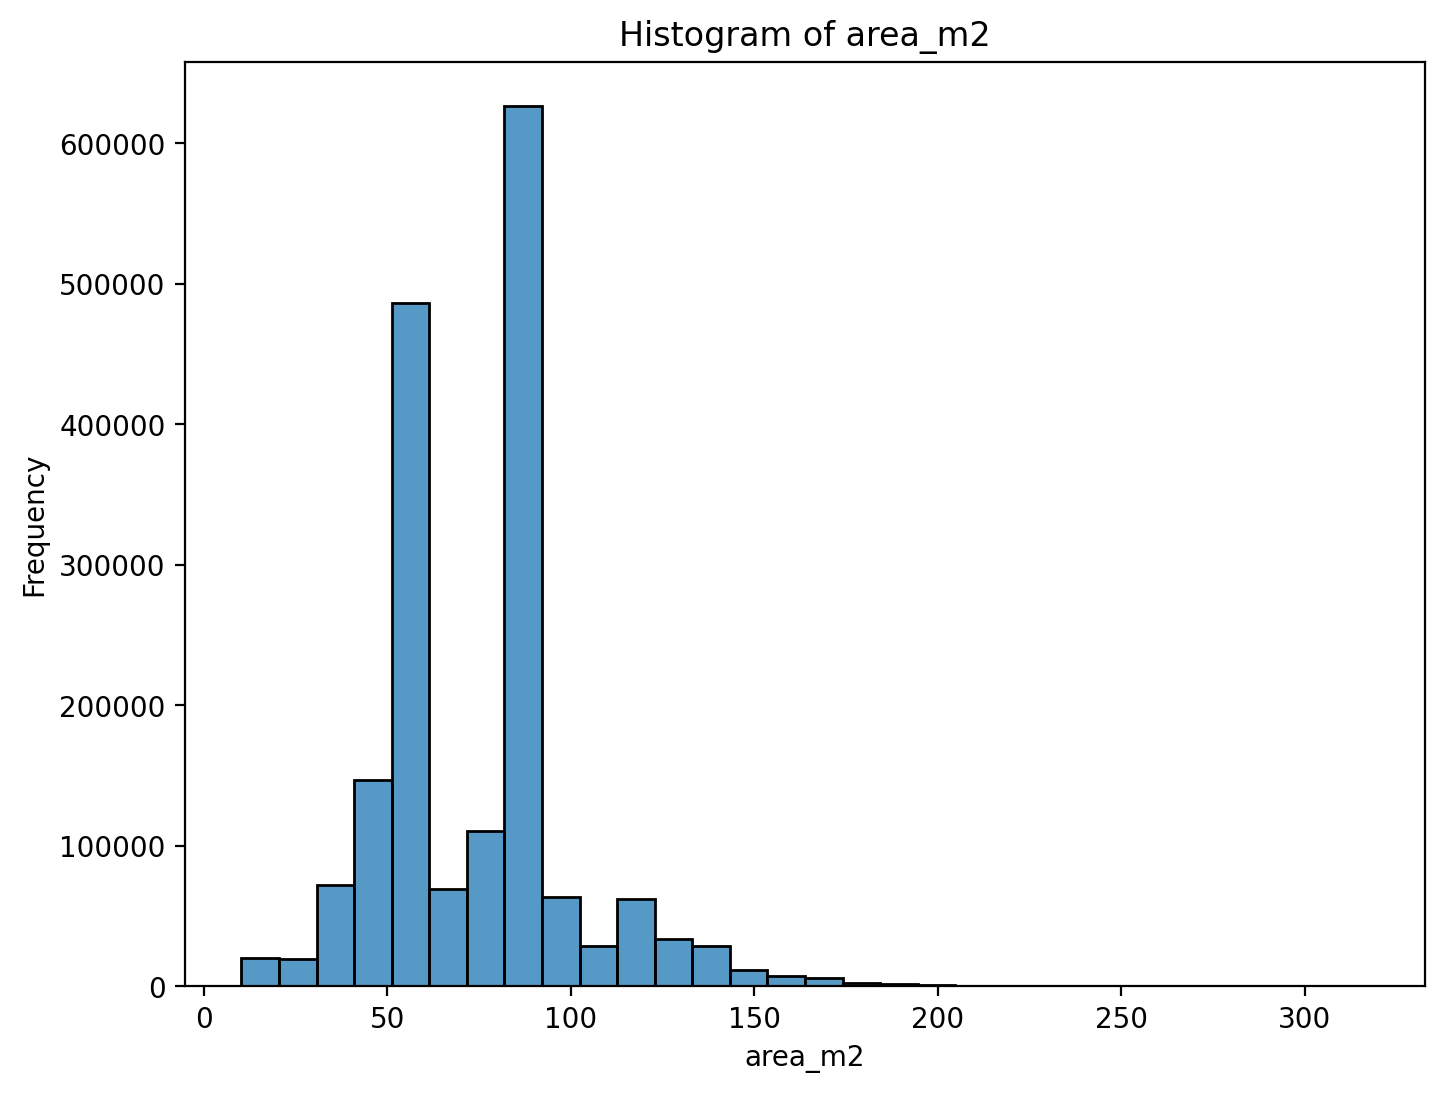

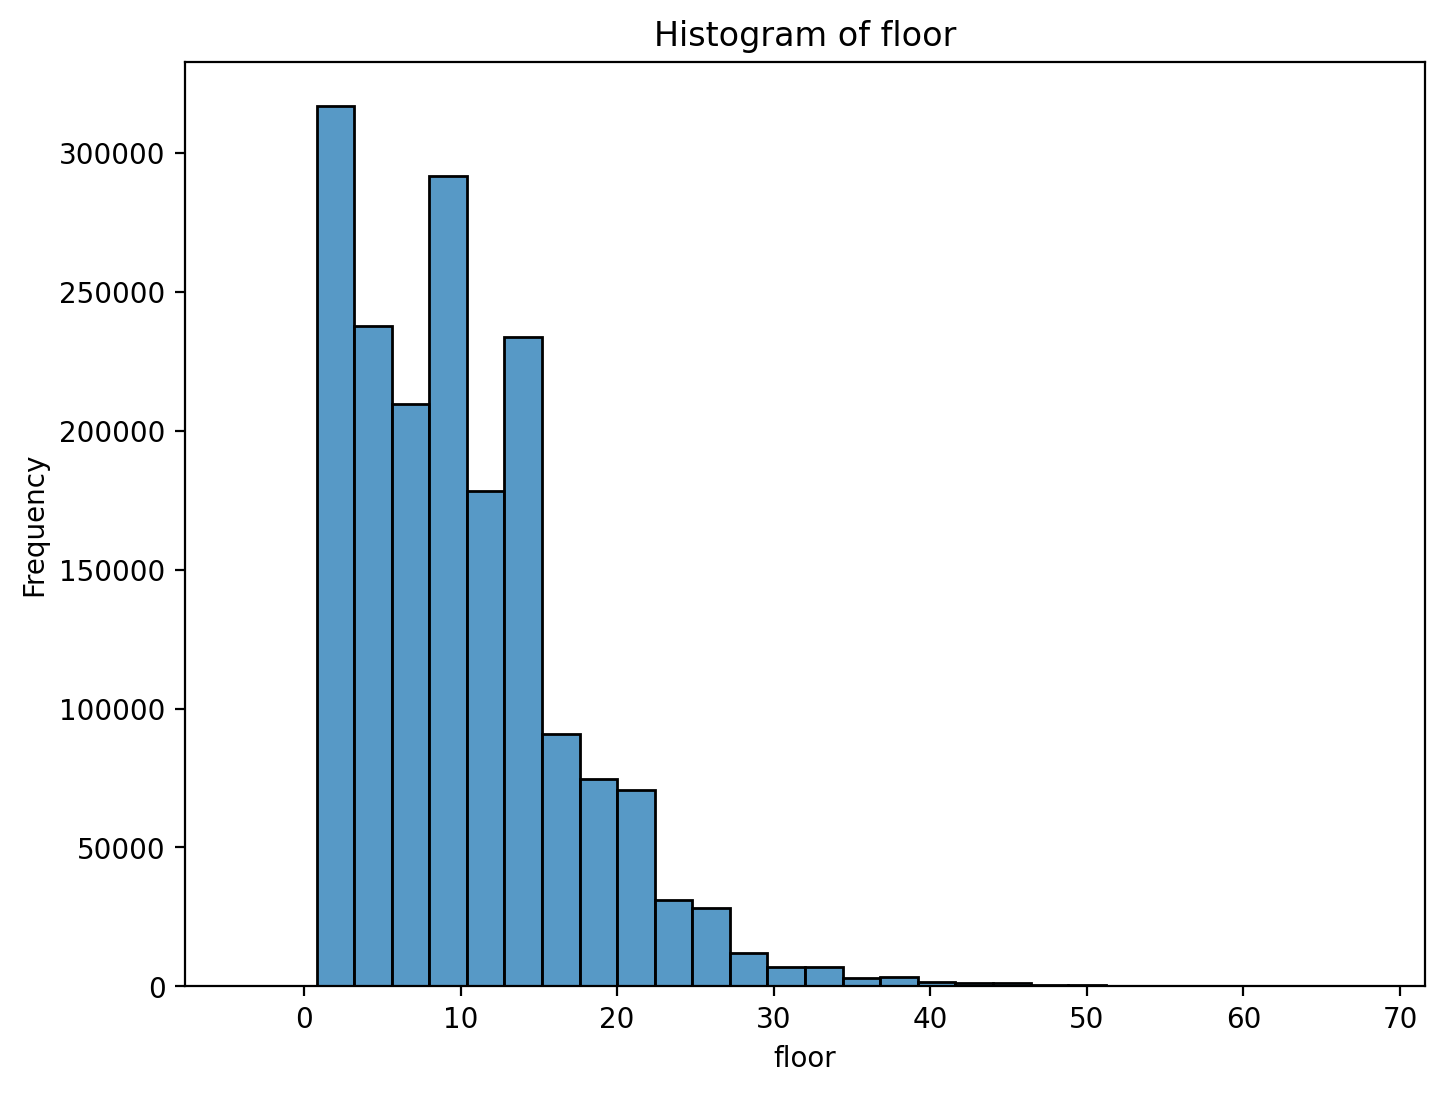

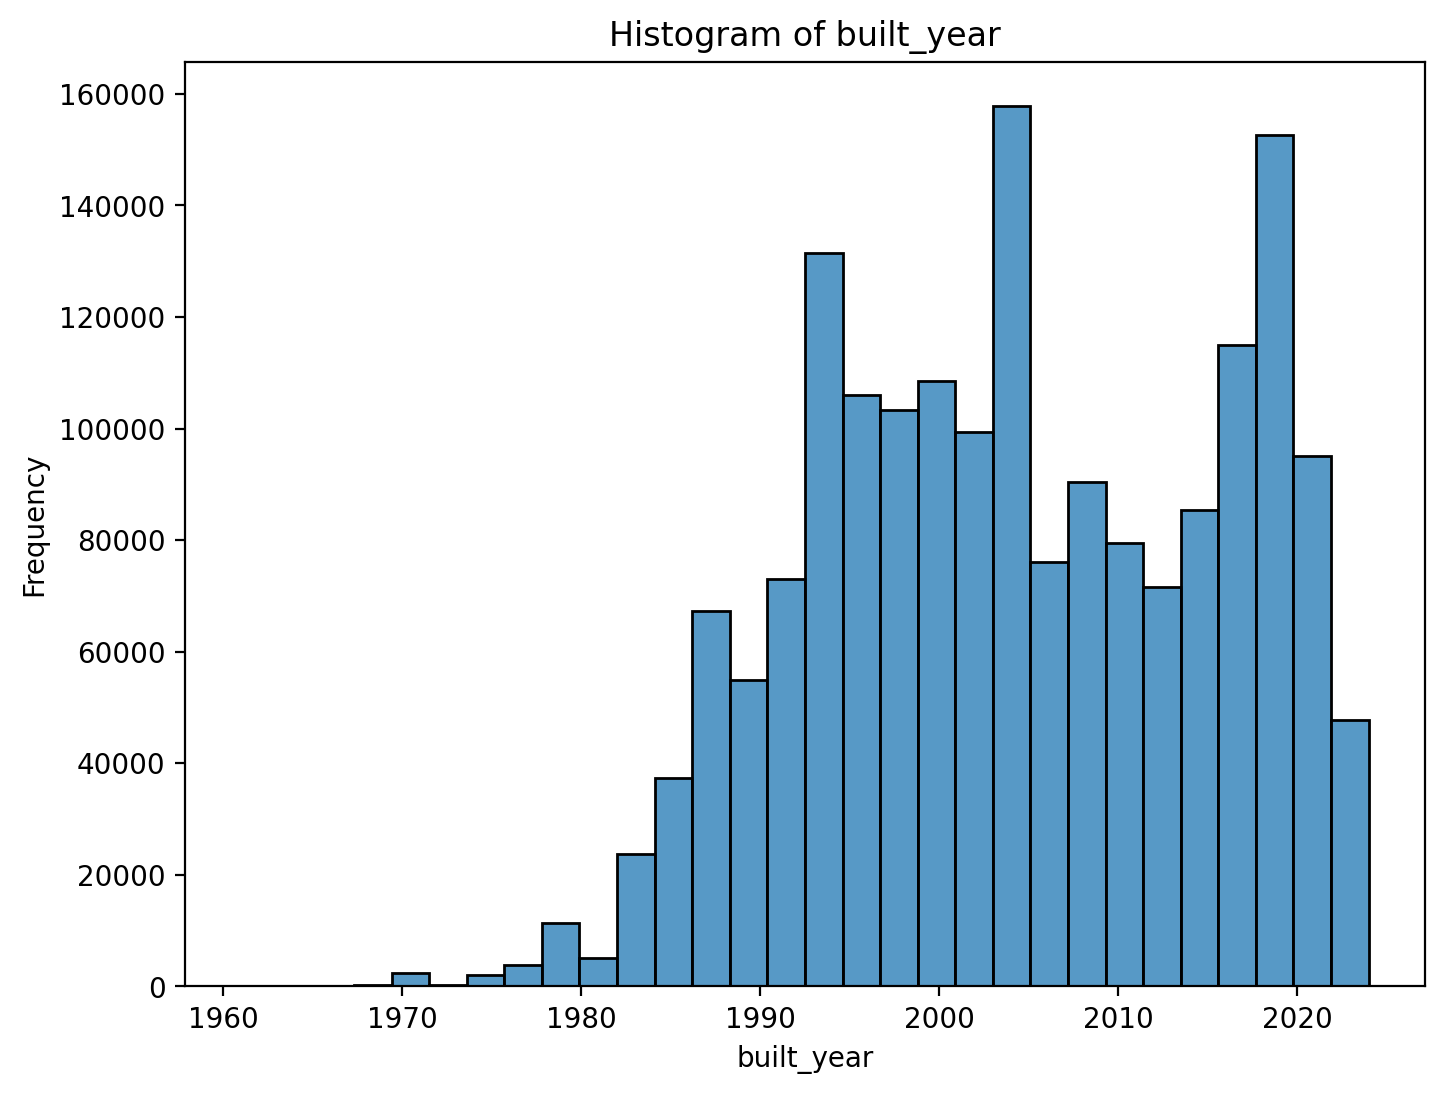

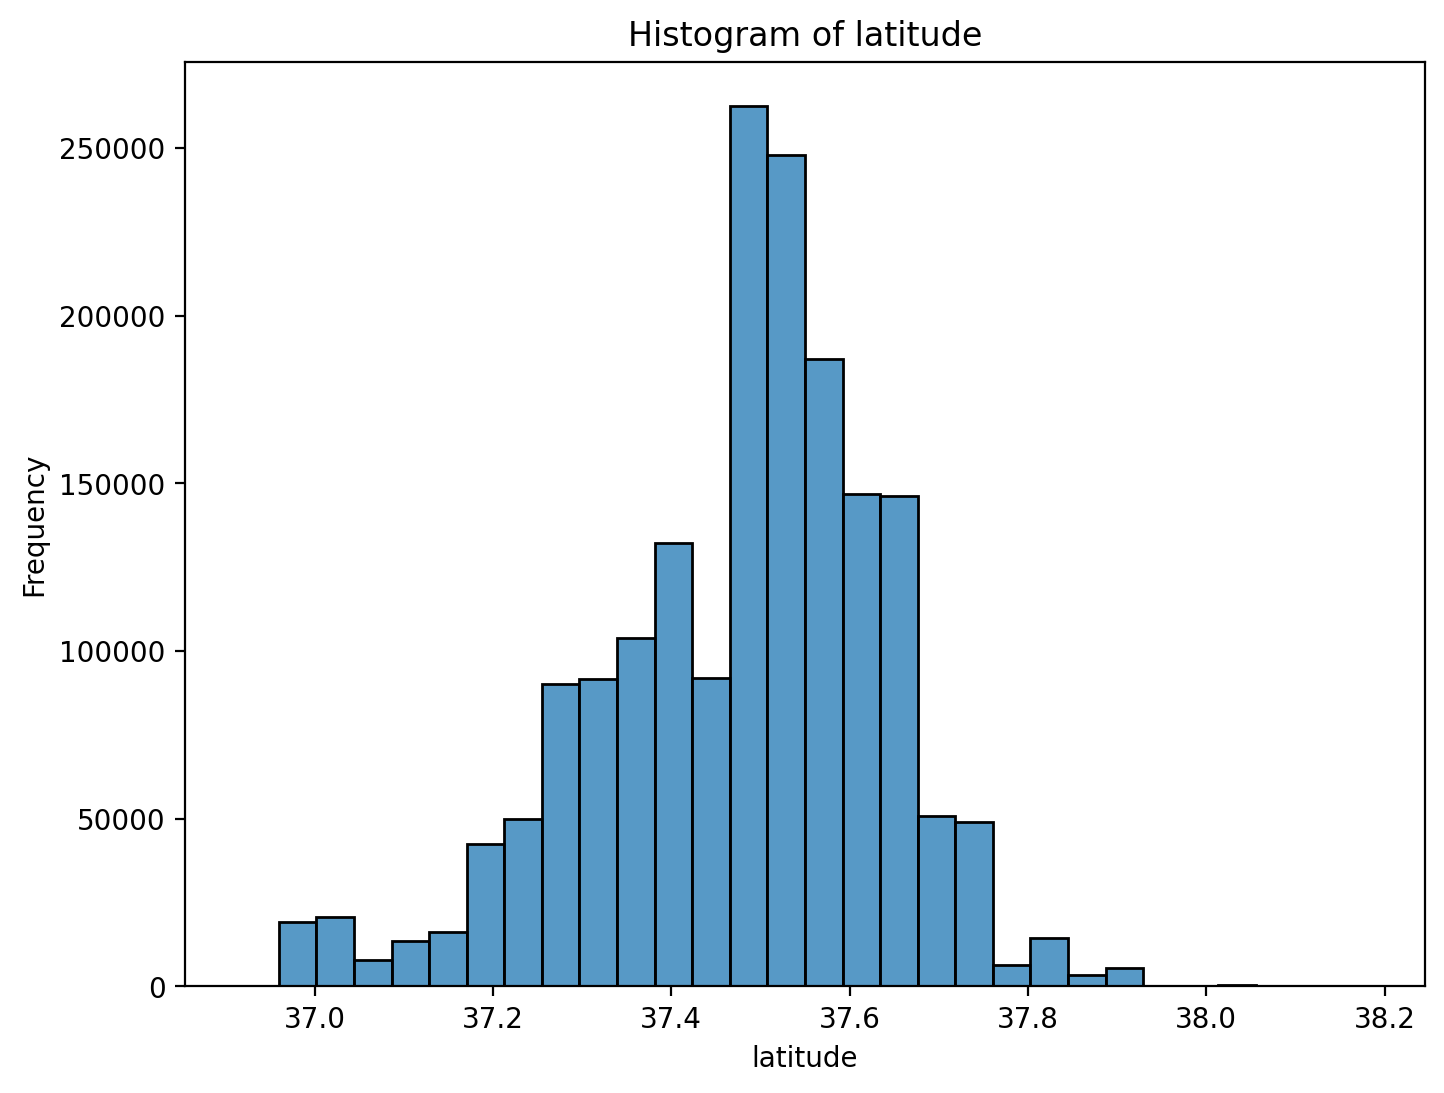

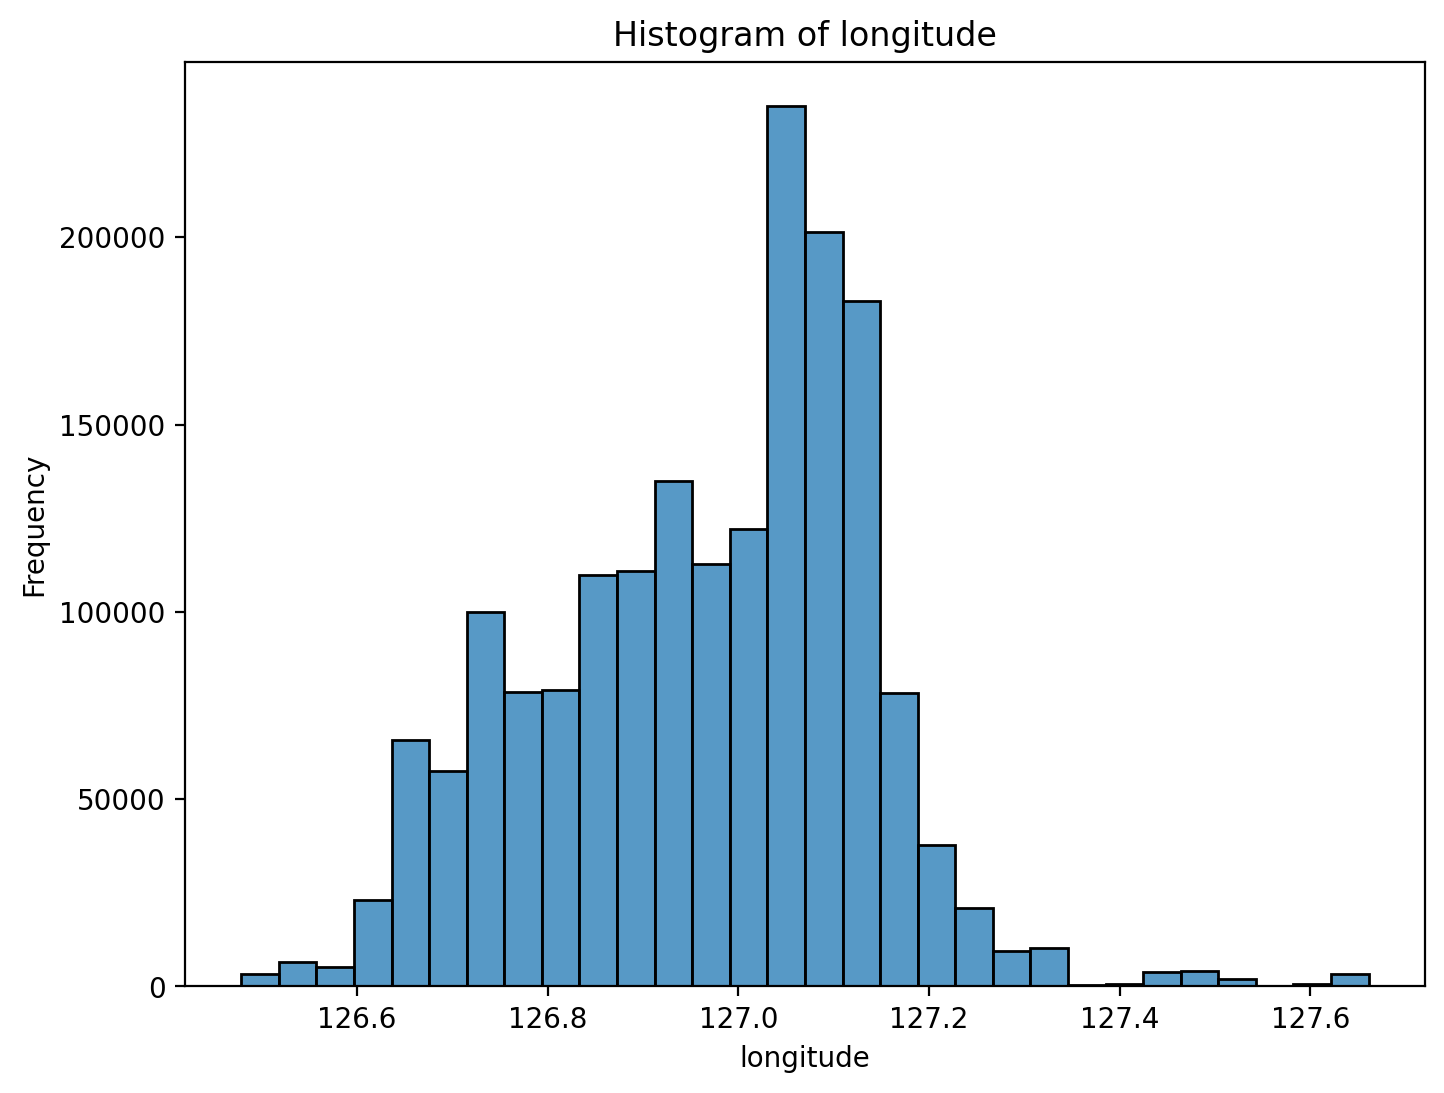

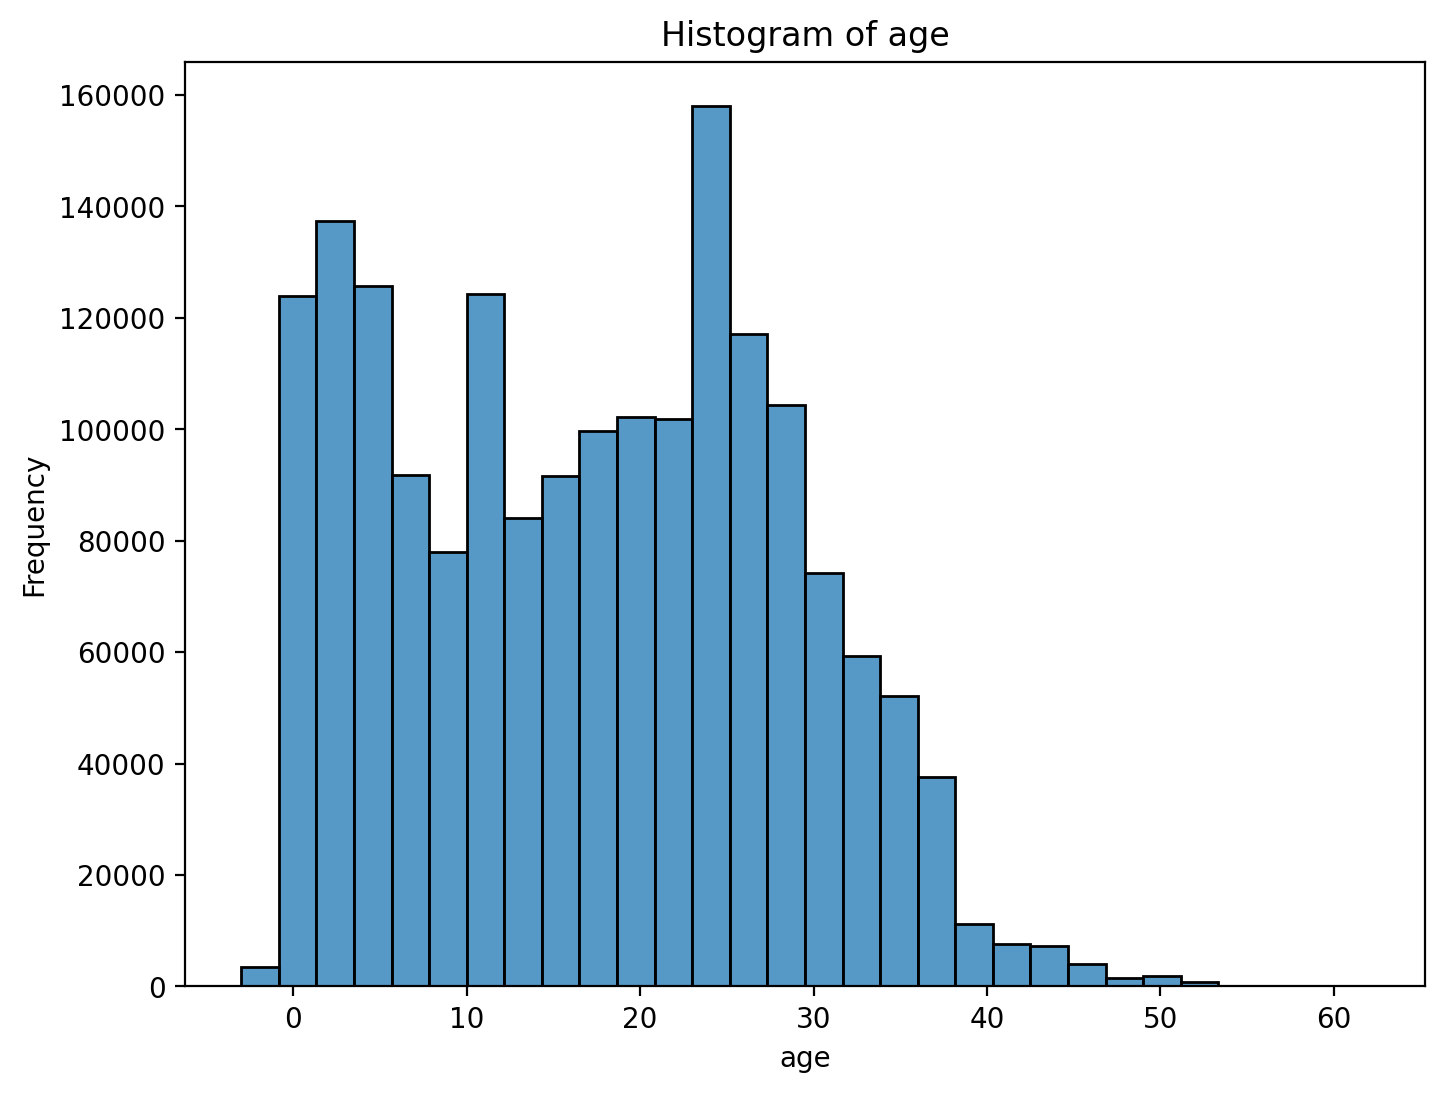

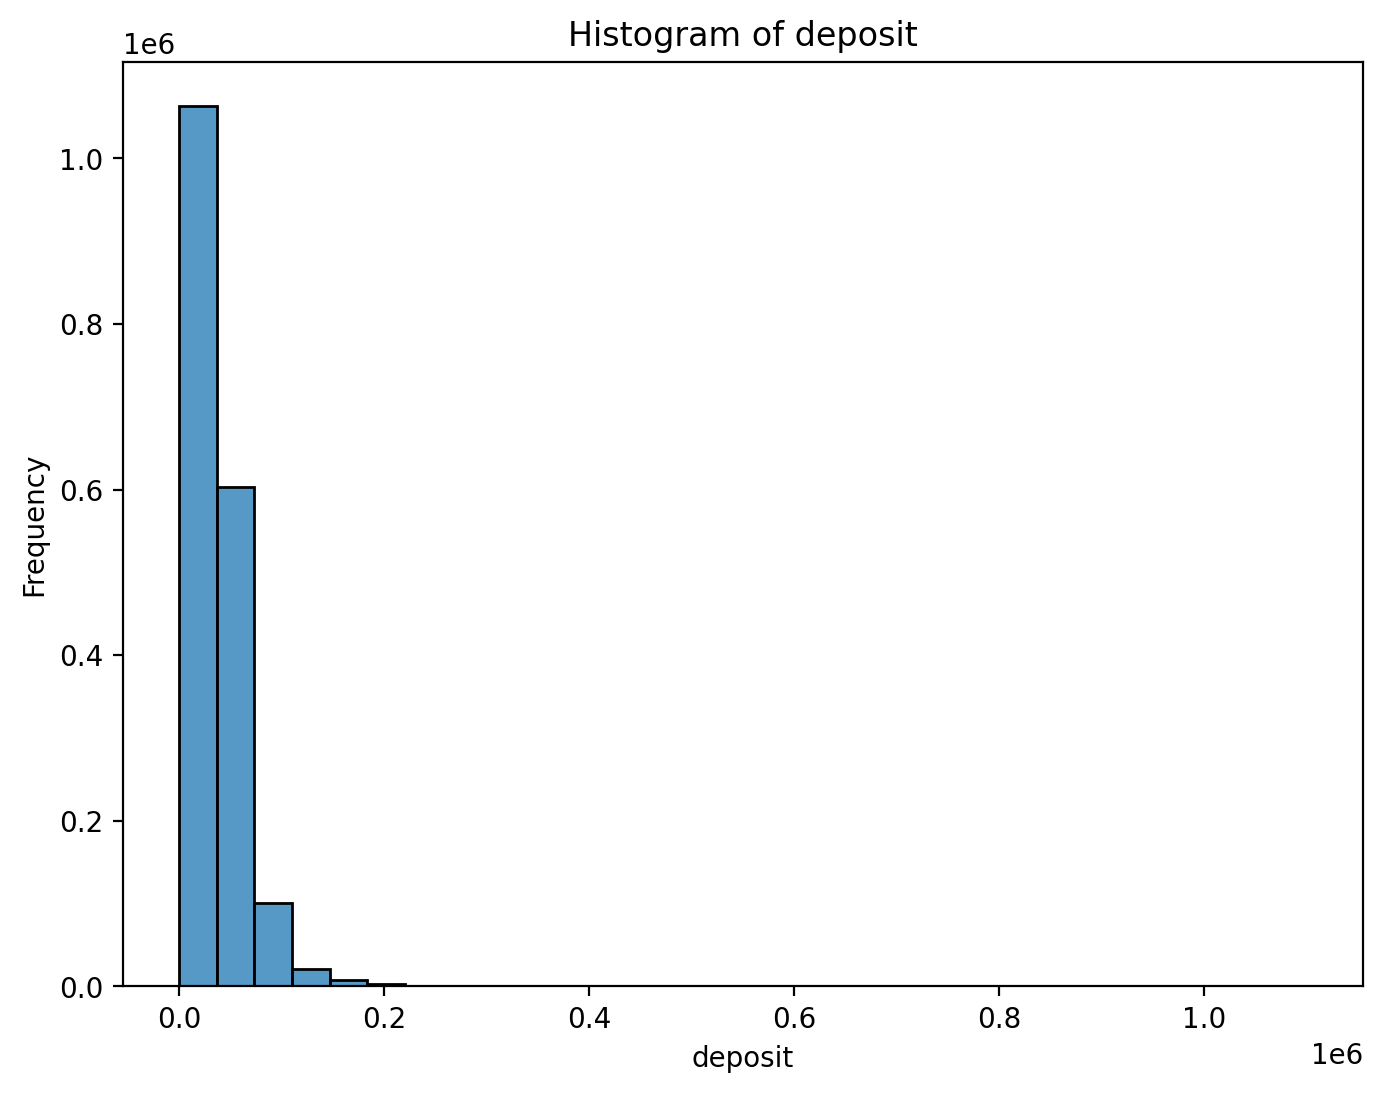

In [29]:
df_filtered = df_eda.drop(columns=['index', 'contract_year_month', 'contract_day', 'contract_type'])
plot_histograms(df_filtered)

### 면적

- 면적이 넓을 수록 가격이 높아지는 경향이 있음
- 오래된 집일 수록 면적이 넓은 경향이 있음

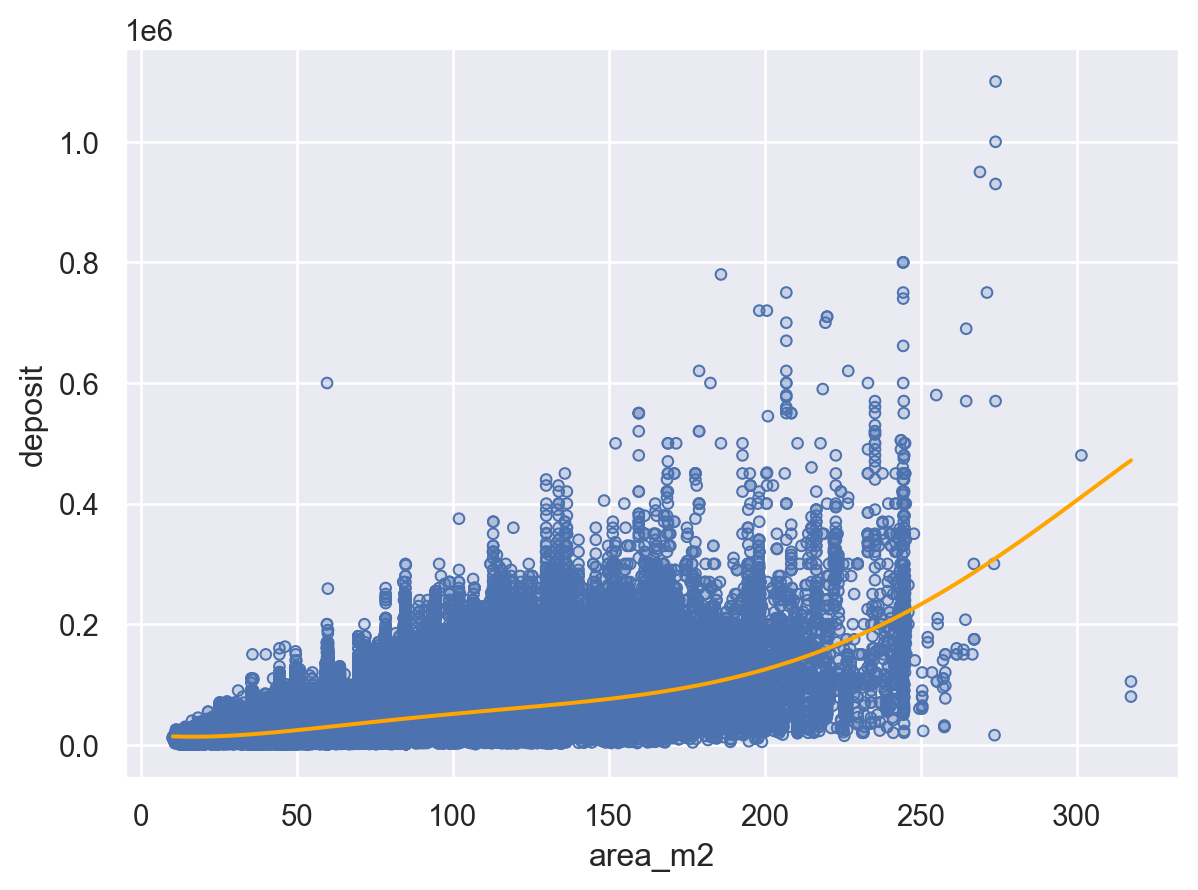

In [20]:
(
    so.Plot(df_eda,x='area_m2',y='deposit')
    .add(so.Dots())
    .add(so.Line(color='orange'),so.PolyFit(5)) # 색상 변경하기
)

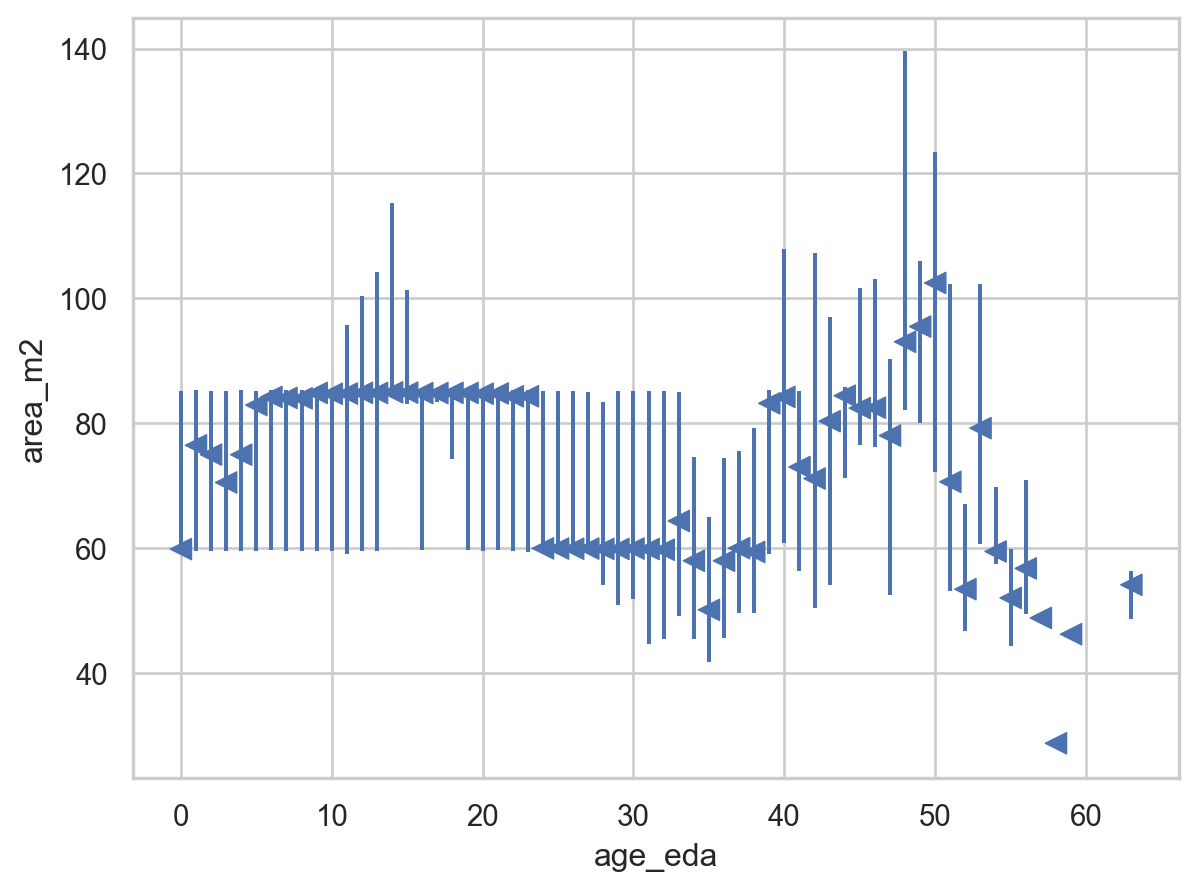

In [51]:
rangeplot(df_eda,x='age_eda',y='area_m2')

### contract_type(0:신규,1:갱신,2:모름)
순서 없음 -> one-hot encoding


- 평균 기준
    - 갱신 > 신규 > 모름 큰 차이는 없음
    - 관련된 정보를 찾아보면 좋을 거 같음
    - 근데 모름 빈도가 많음

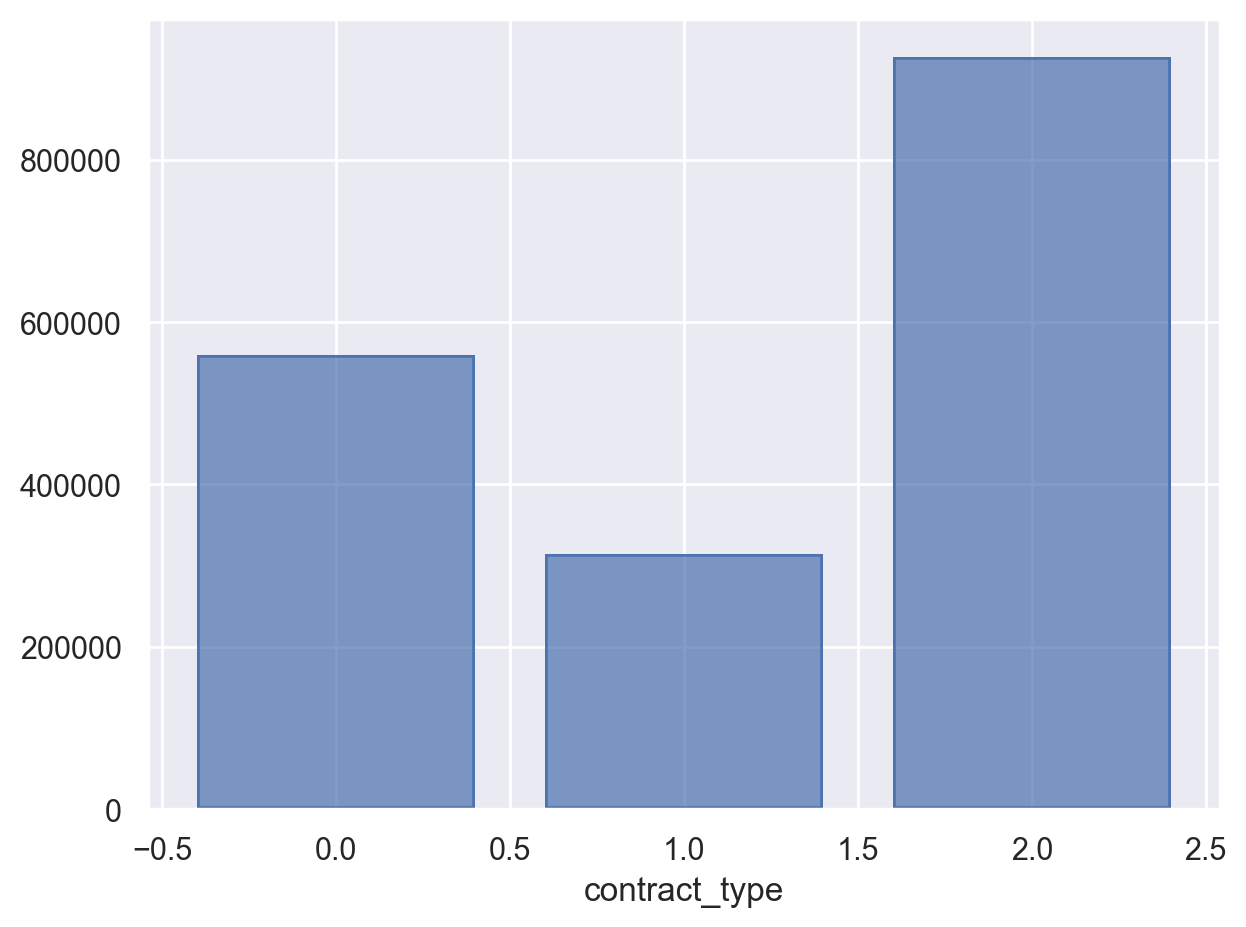

In [21]:
(
    so.Plot(df_eda, x="contract_type")
    .add(so.Bar(), so.Count())  # category type의 변수는 순서가 존재. 
                                # 그렇지 않은 경우 알바벳 순서로. 
).show()

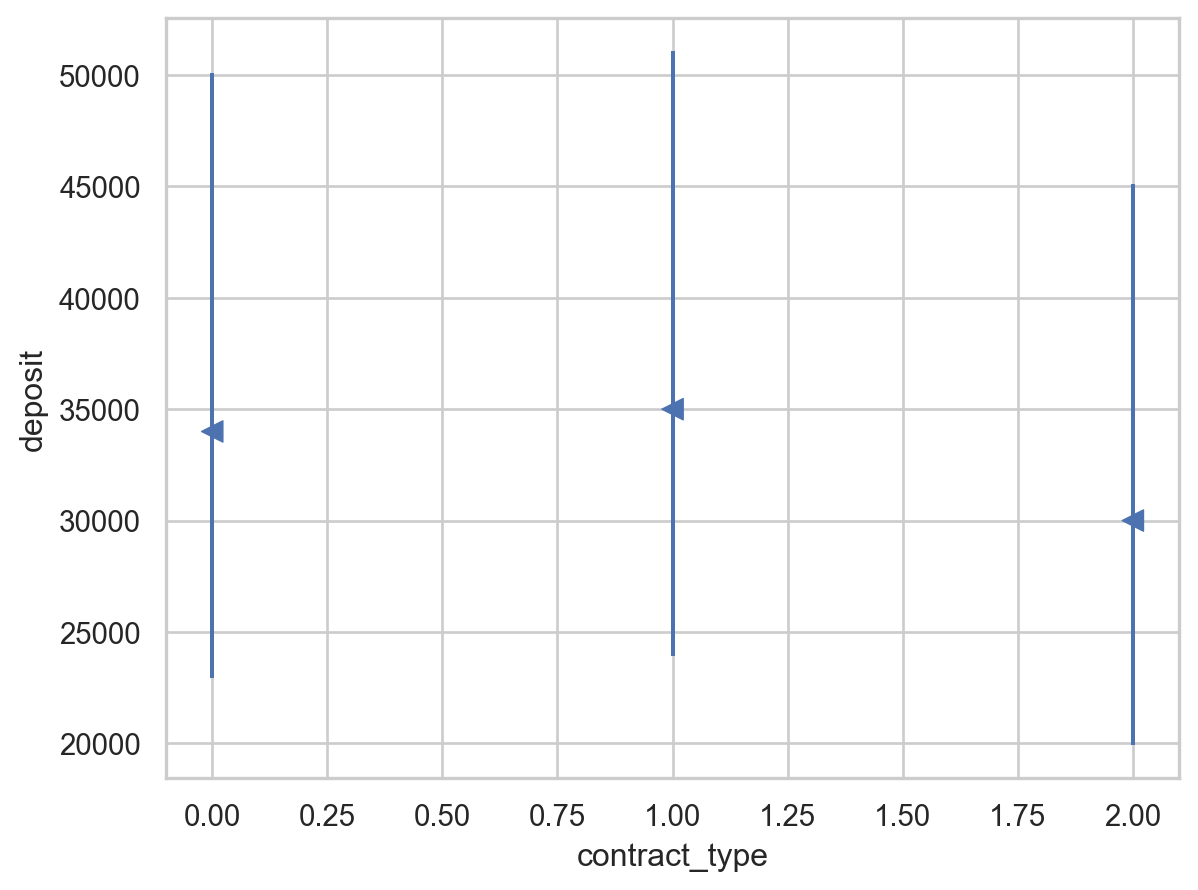

In [22]:
rangeplot(df_eda,x='contract_type',y='deposit')

### age

- 신식 건물일 수록 비싸지 않을까?
- age가 정확하게 어떤 걸 의미 : 계약일자 빼기 built_year
- age 음수인 경우 : 부호가 잘 못 들어감

In [19]:
display(train_data[train_data['age'] <= 0]['age'].value_counts())
print("건물 나이가 음수인 경우 :",train_data[train_data['age'] == 0 ]['age'].count())

age
 0    83870
-1     3419
-2       28
-3        4
Name: count, dtype: int64

건물 나이가 음수인 경우 : 83870


In [20]:
train_data[train_data['age']==-3]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
31588,31588,112.86,201906,10,2,5,2022,37.43,127.00,-3,146900.00
445834,445834,84.95,202109,7,0,16,2024,37.82,127.06,-3,26000.00
987149,987149,84.72,201907,20,2,1,2022,37.60,126.92,-3,16100.00
1112268,1112268,84.99,202012,1,2,6,2023,37.54,127.08,-3,80000.00


In [21]:
train_data[train_data['age']==-2]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
6101,6101,53.81,201905,2,2,5,2021,37.69,127.21,-2,17000.00
6102,6102,56.96,201905,2,2,9,2021,37.69,127.21,-2,17900.00
6103,6103,56.96,201905,2,2,16,2021,37.69,127.21,-2,17900.00
6104,6104,49.34,201905,2,2,9,2021,37.69,127.21,-2,14600.00
6106,6106,53.81,201905,4,2,11,2021,37.69,127.21,-2,17000.00
6107,6107,56.96,201905,4,2,10,2021,37.69,127.21,-2,17900.00
6114,6114,49.34,201905,14,2,8,2021,37.69,127.21,-2,14600.00
6117,6117,49.34,201905,17,2,11,2021,37.69,127.21,-2,14600.00
6130,6130,53.81,201906,1,2,7,2021,37.69,127.21,-2,17000.00
6134,6134,56.96,201906,3,2,16,2021,37.69,127.21,-2,17900.00


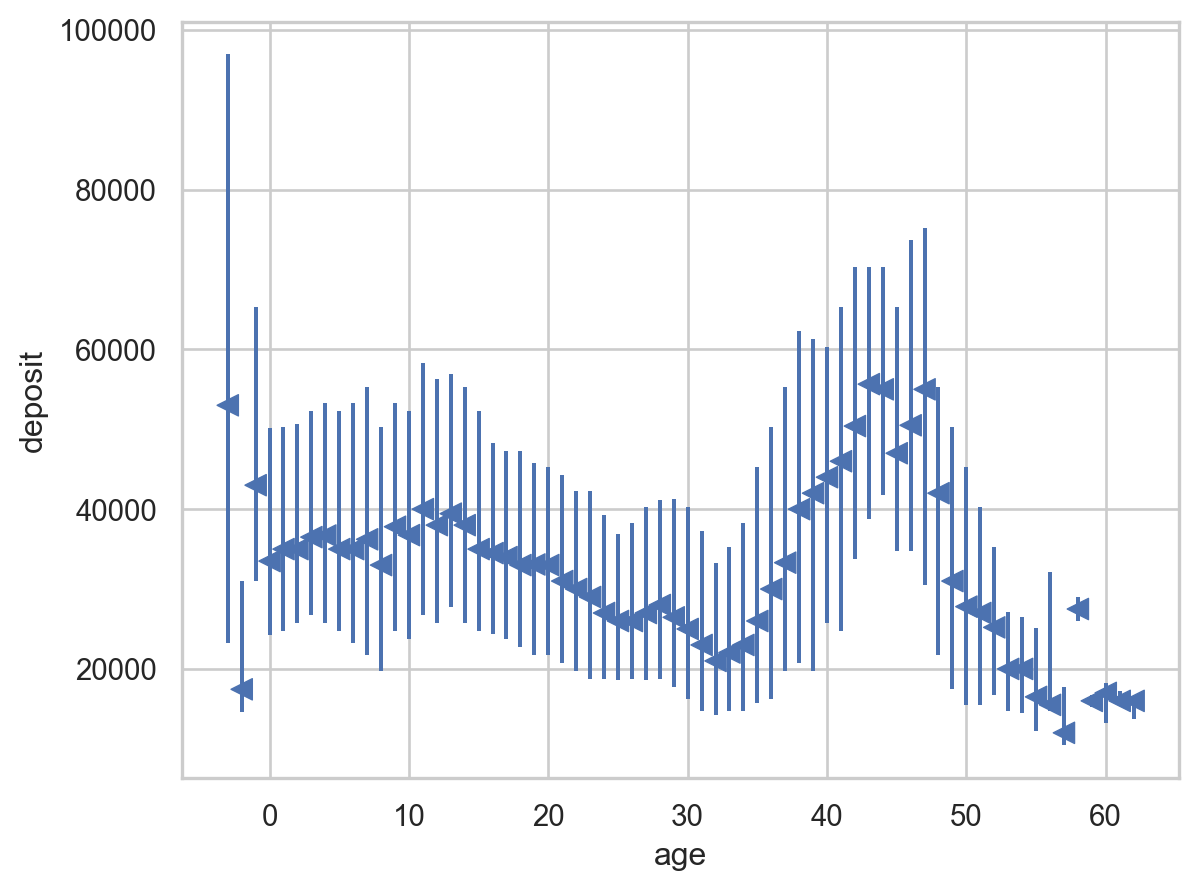

In [25]:
rangeplot(df_eda,x='age',y='deposit')

- 최신건물이라고 엄청 비싸지는 않음
- 40 - 50 묶어서 저 구간은 확인해보면 좋을 거 같음 -> 건물 크기가 커서 비싸다

### floor

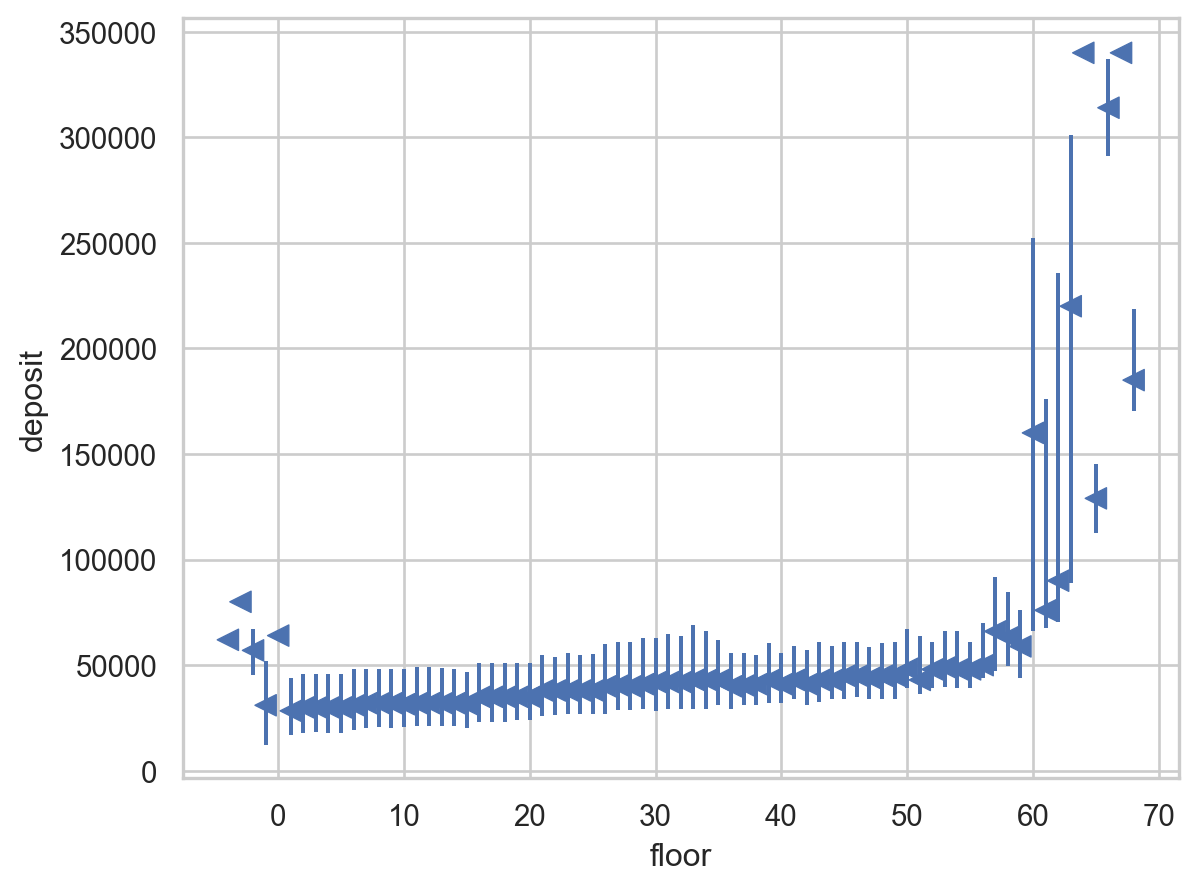

In [52]:
rangeplot(df_eda,x='floor',y = 'deposit')

In [54]:
df_eda[df_eda['floor'] <= 0]['floor'].value_counts()

floor
-1    57
-2     8
 0     3
-4     1
-3     1
Name: count, dtype: int64

In [55]:
df_eda[df_eda['floor'] == 0]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,age_eda,year,month
99412,99412,84.90,2019-06-01,29,2,0,1992,37.37,127.11,27,64000.00,32,2019,6
99413,99413,84.90,2019-06-01,29,2,0,1992,37.37,127.11,27,64000.00,32,2019,6
99414,99414,84.90,2019-06-01,29,2,0,1992,37.37,127.11,27,64000.00,32,2019,6


### 위도 경도

- 일단 주소로 변환 후 지도 위에 표시하는 방향으로 eda 진행 
    -  지오코딩 너무 오래걸림 일단 지도 위에 표시하는 걸로

- 근처에 학교가 있는지 확인해봄 ,다른 데이터셋과 같이 이용할 수 있음 일단은 학교만 먼저 이용함

### 계약 날짜 - 금리랑 상관 있을 거 같음

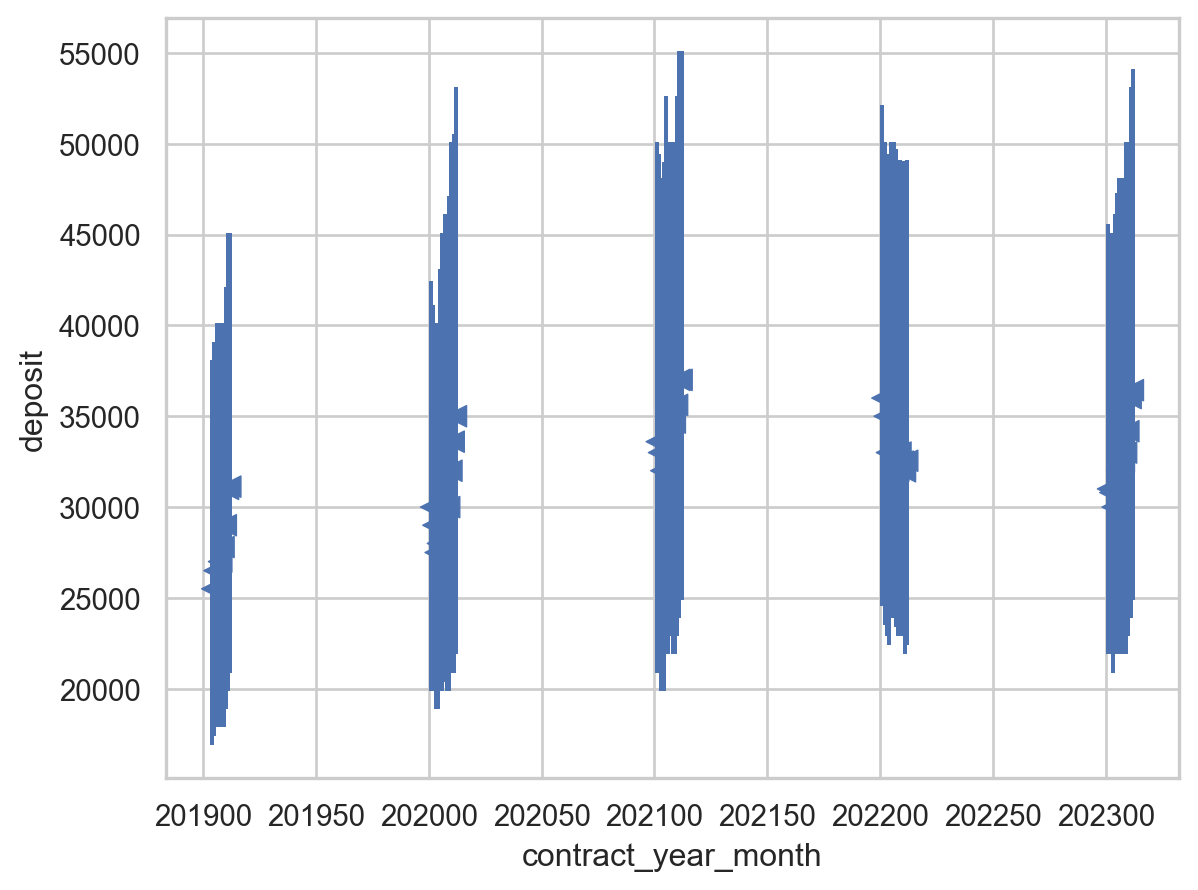

In [18]:
rangeplot(df_eda,x='contract_year_month',y='deposit')

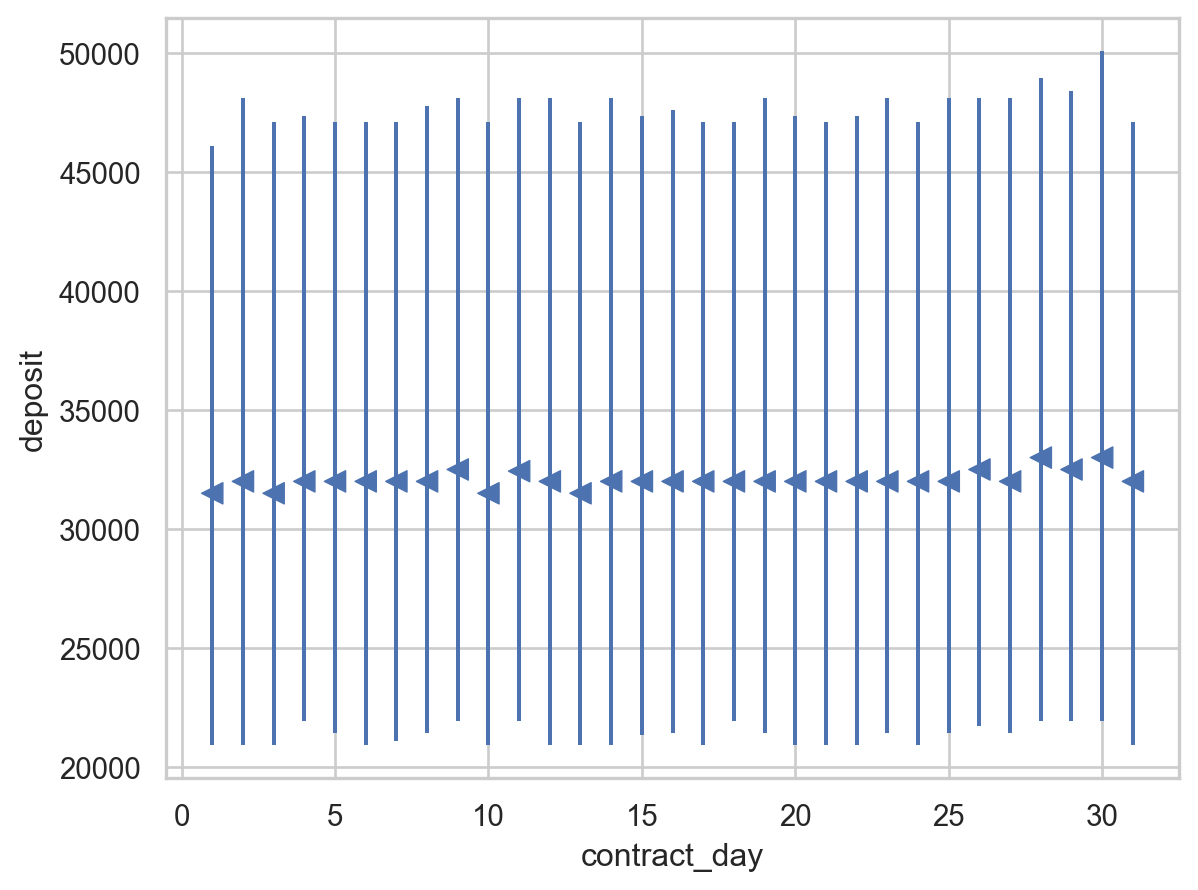

In [47]:
rangeplot(df_eda,x='contract_day',y='deposit')

# 대회에 필요한 데이터만 활용하기

In [3]:
columns_needed = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude', 'deposit']
columns_needed_test = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude']
train_data = train_data[columns_needed]
test_data = test_data[columns_needed_test]

# Holdout 데이터셋 설정 (예: 2023년 7월부터 12월까지의 데이터)

In [5]:
holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

# 학습 데이터와 정답 데이터 분리

In [6]:
X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

# LightGBM 모델 훈련

In [9]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 1594362, number of used features: 7
[LightGBM] [Info] Start training from score 37814.733261


LGBMRegressor(random_state=42)

# Holdout 데이터셋에 대한 성능 확인

In [10]:
lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

Holdout 데이터셋 성능:
LightGBM MAE: 7904.04


------------

# Sample Submission 제출하기

In [27]:
lgb_test_pred = lgb_model.predict(X_test)
sample_submission['deposit'] = lgb_test_pred
sample_submission.to_csv('output.csv', index=False, encoding='utf-8-sig')